# Run EALSTM with 365 days of input

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

In [4]:
np.array(sorted([d.name for d in (data_dir / "models/").glob("*timestep*")]))

array(['2020_04_07:171723_one_timestep_forecast',
       '2020_04_13:090536_one_timestep_forecast',
       '2020_04_13:091211_one_timestep_forecast',
       '2020_04_13:144437_one_timestep_forecast',
       '2020_04_13:155432_one_timestep_forecast',
       '2020_04_13:171738_one_timestep_forecast', 'one_timestep_forecast',
       'one_timestep_forecast_19epoch_static',
       'one_timestep_forecast_1epoch',
       'one_timestep_forecast_1epoch_static',
       'one_timestep_forecast_20epoch',
       'one_timestep_forecast_20epoch_static',
       'one_timestep_forecast_ORIGINAL'], dtype='<U39')

In [5]:
EXPERIMENT =      '2020_04_13:090536_one_timestep_forecast'
TRUE_EXPERIMENT = 'one_timestep_forecast'
TARGET_VAR =      'discharge_spec'
N_EPOCHS = 10

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

# Read in data

In [8]:
# read in model
ealstm = load_model(data_dir / f'models/{EXPERIMENT}/ealstm/model.pt')

Using the Dynamic DataLoader
	Target Var: discharge_spec
	Test Years: [2011 2012 2013 2014 2015 2016]


In [9]:
# read in model predictions
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)
ealstm_pred['station_id'] = ealstm_pred['station_id'].astype(int)

Reading all .nc files from: data/models/2020_04_13:090536_one_timestep_forecast/ealstm
All datasets loaded. Now combining ...


In [10]:
# read in the training data
ds = xr.open_dataset(Path(f'data/features/{TRUE_EXPERIMENT}/data.nc'))

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(Path(f'data/interim/static/data.nc'))
all_static['station_id'] = all_static['station_id'].astype(int)
static_ds = all_static.drop(ealstm.static_ignore_vars)

ds['station_id'] = ds['station_id'].astype(int)
ds

<xarray.Dataset>
Dimensions:              (station_id: 671, time: 16436)
Coordinates:
  * station_id           (station_id) int64 1001 2001 2002 ... 106001 107001
  * time                 (time) datetime64[ns] 1970-10-01 ... 2015-09-30
Data variables:
    precipitation        (time, station_id) float64 ...
    discharge_spec       (time, station_id) float64 ...
    peti                 (time, station_id) float64 ...
    target_var_original  (time, station_id) float64 ...

In [11]:
# get the observed y_test
times = ealstm_pred.time.values
station_ids = ealstm_pred.station_id.values

In [12]:
# Get the predicted and true data
# 'target_var_original' 'discharge_spec'
y_test = ds[TARGET_VAR].sel(station_id=station_ids).sel(time=times)
true_da = y_test

# pred_da = np.exp(ealstm_pred['preds']) - 0.001
pred_da = ealstm_pred['preds']

print(f"{true_da.mean().values}, {true_da.std().values}")
print(f"{pred_da.mean().values}, {pred_da.std().values}")

# check that they are more or less correctly transformed
assert np.isclose(true_da.mean().values, pred_da.mean().values, atol=0.1)
# assert np.isclose(true_da.std().values, pred_da.std().values, atol=0.4)

print('\n')
display("pred_da coordinates", pred_da.coords)
display("true_da coordinates", true_da.coords)

-0.10497379489296456, 1.312754544199556
-0.1735432893037796, 0.557020366191864




'pred_da coordinates'

Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

'true_da coordinates'

Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

In [13]:
# join the true and the pred data into one pd.DataFrame
df = (
    join_true_pred_da(
        true_da, pred_da
    ).to_dataframe()
    .reset_index()
    .set_index('time')
)

df.head()

,station_id,discharge_spec,preds
time,,,
2011-01-01,1001,1.261581,-0.360403
2011-01-02,1001,0.986190,-0.328166
2011-01-03,1001,0.912684,-0.287921
2011-01-04,1001,0.756591,-0.265577
2011-01-05,1001,1.570905,0.098262


In [14]:
# print the model training features
logy=True
ljust = 30

print(
    "", "Target Var: ".ljust(ljust), f"{ealstm.target_var}\n",
    "Log y: ".ljust(ljust), f"{logy}\n",
    "Normalize y: ".ljust(ljust), f"{ealstm.normalize_y}\n",
    "Train Years: ".ljust(ljust), f"{ds['time.year'].min().values}: {min(ealstm.test_years) -1}\n",
    "Test Years: ".ljust(ljust), f"{ealstm.test_years}\n",
    "N Stations: ".ljust(ljust), f"{len(df.station_id.unique())}\n",
    "Dynamic Variables: ".ljust(ljust), f"{[v for v in list(ds.data_vars) if v not in list(set(ealstm.dynamic_ignore_vars))]}\n",
    "Static Variables: ".ljust(ljust), f"{list(static_ds.data_vars)}\n", 
    "Sequence Length: ".ljust(ljust), f"{ealstm.seq_length}\n", 
    "Final Linear Layer size: ".ljust(ljust), f"{ealstm.dense_features}\n", 
    "Static Embedding Size: ".ljust(ljust), f"{ealstm.static_embedding_size}\n", 
#     "VAR: ".ljust(ljust), f"{VAR}\n", 
)

 Target Var:                    discharge_spec
 Log y:                         True
 Normalize y:                   True
 Train Years:                   1970: 2010
 Test Years:                    [2011 2012 2013 2014 2015 2016]
 N Stations:                    662
 Dynamic Variables:             ['precipitation', 'peti']
 Static Variables:              ['dpsbar', 'porosity_hypres', 'conductivity_hypres', 'slope_fdc', 'baseflow_index', 'aridity', 'frac_snow', 'dwood_perc', 'ewood_perc', 'crop_perc', 'urban_perc', 'reservoir_cap']
 Sequence Length:               365
 Final Linear Layer size:       [128, 1]
 Static Embedding Size:         None



# run performance metrics


In [15]:
from src.analysis.evaluation import (r2_score, rmse, spatial_rmse, spatial_r2, spatial_nse)
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse

In [16]:
# calculate performance for each station (collapse time)
rmse_da = spatial_rmse(y_test, pred_da)
r2_da = spatial_r2(y_test, pred_da)
nse_da = spatial_nse(y_test, pred_da)

# calculate performance for each station (collapse space)
rmse_time = temporal_rmse(y_test, pred_da)
r2_time = temporal_r2(y_test, pred_da)
nse_time = temporal_nse(y_test, pred_da)

In [17]:
print(f"Mean Station RMSE: {rmse_da.mean().values:.2f}")
print(f"Mean Station NSE: {(nse_da.where(nse_da > -np.inf)).mean().values:.2f}")
print(f"Mean Station R2: {r2_da.mean().values:.2f}")

print(f"\n\nMean Time RMSE: {rmse_time.mean().values:.2f}")
print(f"Mean Time NSE: {nse_time.mean().values:.2f}")
print(f"Mean Time R2: {r2_time.mean().values:.2f}")

Mean Station RMSE: 0.97
Mean Station NSE: -2.01
Mean Station R2: 0.36


Mean Time RMSE: 1.03
Mean Time NSE: -2.62
Mean Time R2: 0.22


In [18]:
# rmse and r2 df
metrics_df = rmse_da.to_dataframe().drop(columns='time').rename(columns={"preds": "rmse"}).join(
    r2_da.to_dataframe().drop(columns='time').rename(columns={"preds": "r2"})
)
metrics_df = metrics_df.join(
    nse_da.to_dataframe().rename(columns={"preds": "nse"})
)

metrics_df = metrics_df.reset_index()
metrics_df.head()

,station_id,rmse,r2,nse
0,1001,0.983667,0.385223,-1.488393
1,2001,0.787642,0.361400,-1.420722
2,2002,0.877490,0.483913,-1.106546
3,3003,0.987824,0.596740,-0.701658
4,4001,1.455362,0.304869,-3.661583


In [19]:
# TEMPORAL rmse and r2 df
metrics_time = rmse_time.to_dataframe().rename(columns={TARGET_VAR: "rmse"}).join(
    r2_time.to_dataframe().rename(columns={TARGET_VAR: "r2"})
)
metrics_time = metrics_time.join(
    nse_time.to_dataframe().rename(columns={TARGET_VAR: "nse"})
)

metrics_time = metrics_time.reset_index()
metrics_time['time'] = [pd.to_datetime(t) for t in metrics_time.time]
metrics_time.head()

,time,rmse,r2,nse
0,2011-01-01,1.131584,0.073409,-7.260175
1,2011-01-02,0.928668,0.060682,-8.890734
2,2011-01-03,0.941530,0.066064,-4.513857
3,2011-01-04,1.162528,0.208784,-2.387226
4,2011-01-05,0.925563,0.425212,-1.537347


## Performance Plots

In [22]:
nse_df = nse_da.sortby(nse_da).to_dataframe().reset_index().dropna()

# replace the negative infinity value
# nse_df['error'] = (nse_df.preds == -np.inf)
# nse_df.loc[nse_df.preds == -np.inf, "preds"] = -125

# ignore the negative infinity value
# nse_df = nse_df.loc[nse_df.preds != -np.inf]

# get cumsum of index
nse_df['index'] = nse_df.index

nse_df['negative'] = nse_df.preds < 0

nse_df.head()

,station_id,preds,index,negative
0,39125,-inf,0,True
1,27038,-69.076890,1,True
2,39088,-68.706758,2,True
3,39120,-58.174668,3,True
4,39127,-41.920918,4,True


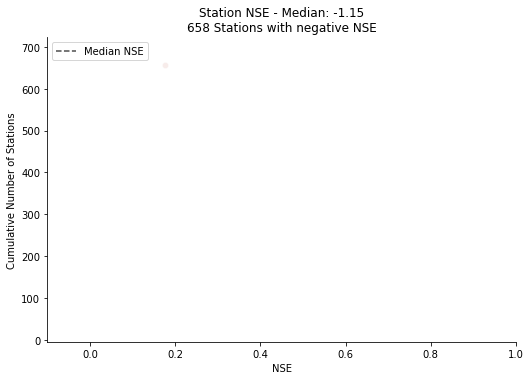

In [23]:
data = nse_df.loc[nse_df['preds'] >= -0.1]
median_nse = nse_df.loc[nse_df.preds != -np.inf, 'preds'].median()

scale = 0.7
fig, ax = plt.subplots(figsize=(12*scale, 8*scale))

# plot the points
# sns.lineplot(x='preds', y='index', ax=ax, data=data)
sns.scatterplot(x='preds', y='index', hue='negative', x_jitter=2, ax=ax, data=data, alpha=0.4, legend=False)

ymax = int(nse_df['index'].max() * 1.1)
ax.axvline(median_nse, ymin=0, ymax=nse_df['index'].max() / ymax, color='k', ls='--', label='Median NSE', alpha=0.7)

# beautify the plot
ax.set_ylim(-5, ymax)
ax.set_xlim(-0.1, 1)

ax.legend(loc='upper left')

ax.set_title(f'Station NSE - Median: {median_nse:.2f}\n{nse_df.negative.sum()} Stations with negative NSE')
ax.set_xlabel('NSE')
ax.set_ylabel('Cumulative Number of Stations');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

# Crooks and Martinez stations

In [47]:
catchment_ids = ["12002", "15006", "27009", "27034", "27041", "39001",
                 "39081", "43021", "47001", "54001", "54057", "71001", "84013", ]
catchment_ids = [int(c_id) for c_id in catchment_ids]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston",
                   "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [48]:
valid_catchment_ids = [c for (ix, c) in enumerate(catchment_ids) if c in ealstm_pred.station_id.values]
valid_station_name = np.array(catchment_names)[[ix for (ix, c) in enumerate(catchment_ids) if c in ealstm_pred.station_id.values]]
# for ix, (station_id, station_name) in enumerate(zip(valid_catchment_ids, valid_station_name)):
#     print(f"{station_name} ID: {station_id}")
#     print(f"\tRMSE: {rmse_da.sel(station_id=station_id).values:.2f}")
#     print(f"\tNSE: {nse_da.sel(station_id=station_id).values:.2f}")
#     print(f"\tR2: {r2_da.sel(station_id=station_id).values:.2f}")
#     print("\n")

In [49]:
def plot_station_scatter(
    df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None
):
    # select station
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    # plot scatter
    ax.plot(d[target_var], d.preds, 'kx', alpha=0.6, label='Data Point')
    # plot 1:1 line
    line_1_1_x = np.linspace(d[target_var].min(), d[target_var].max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')

    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None,
                station_name: Optional[str] = None):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    # plot the station
    df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

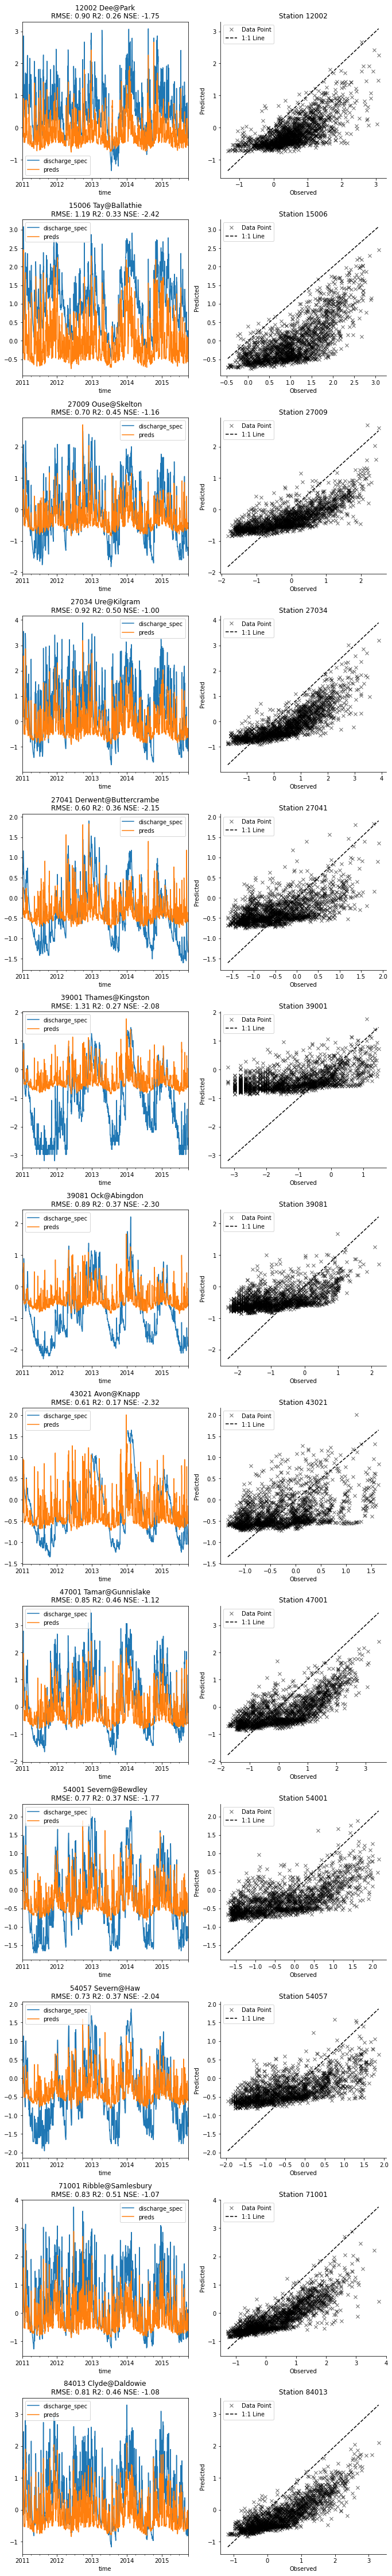

In [50]:
# test_stations = ['22007', '27049', '28018', '31021', '31023', '34004', '35003', '39022', '41029', '51001', '55025', '57004', '83010']
catchment_ids = ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

scale = 0.8
fig, axs = plt.subplots(13, 2, figsize=(12*scale, 6*scale*13))

for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
#     fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
    try:
        plot_station(df, station_id, metrics_df, ax=axs[ix, 0], station_name=station_name)
        plot_station_scatter(df, station_id, metrics_df, axs[ix, 1])
    except TypeError:
        print(f"** {station_name} data does not exist in the predictions! **")
        
    plt.tight_layout()

In [ ]:
for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    print(
        f"{station_title}".ljust(30), 
        f"-- RMSE: {rmse_val:.2f} -- R2: {r2_val:.2f} -- NSE: {nse_val:.2f}"
    )

# Get vars on keyword

In [51]:
from src.preprocess._camels_static_metadata import (get_var_on_dtype, get_vars_on_keywords, get_vars_on_grouping)

In [52]:
static_ds.data_vars

Data variables:
    dpsbar               (station_id) float64 ...
    porosity_hypres      (station_id) float64 ...
    conductivity_hypres  (station_id) float64 ...
    slope_fdc            (station_id) float64 ...
    baseflow_index       (station_id) float64 ...
    aridity              (station_id) float64 ...
    frac_snow            (station_id) float64 ...
    dwood_perc           (station_id) float64 ...
    ewood_perc           (station_id) float64 ...
    crop_perc            (station_id) float64 ...
    urban_perc           (station_id) float64 ...
    reservoir_cap        (station_id) int64 ...

In [53]:
get_vars_on_keywords(static_ds, '_ab').keys()

dict_keys([])

In [54]:
dl = ealstm.get_dataloader('train')
dir(dl)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_datasets',
 '_loc_to_int',
 'batch_file_size',
 'calculate_latlons',
 'calculate_legitimate_target_times',
 'calculate_normalizing_array',
 'clear_nans',
 'data_path',
 'device',
 'dynamic',
 'dynamic_ds',
 'dynamic_ignore_vars',
 'experiment',
 'forecast_horizon',
 'get_max_train_date',
 'get_reducing_dims',
 'get_train_test_times',
 'ignore_vars',
 'legit_target_times',
 'load_data',
 'max_loc_int',
 'mode',
 'normalize_y',
 'normalizing_array',
 'normalizing_array_static',
 'normalizing_dict',
 'pred_months',
 'predict_delta',
 'reducing_dims',
 'resolution',
 'seq_length',
 'shuffle',
 'spatial_mask',
 'static',
 'static_ds',
 'static_ignore_vars',
 'static_normalizing_dict',
 'surrounding_pixels',
 'target_var',
 'timestep_aggs',
 'to_tensor',
 'train_dynamic',
 'use_prev_y_var',
 'valid_test_times',
 'valid_train_times']